# Histograma para generar Vectores de Características
En esta práctica de una imagen obtenemos un parche del cual obtenemos un histograma con las caracteristicas que buscamos y por medio de distancia chi cuadrada comparamos con varios parches de la imagen para encontrar en donde se busca y extraerlos.

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import skimage

from scipy.stats import entropy
from scipy.spatial.distance import cdist
from scipy.stats import moment, variation

import pandas as pd

In [2]:
def chisquare2(observed_values,expected_values):
    '''
    Calcula la distancia Chi entre dos histogramas aún si tiene valores de 0 en el valor esperado.
    
    Args
    ------
    observed_values -- OpenCV Histogram Observado
    expected_values -- OpenCV Histogram Objetivo
    
    Return
    ------
    test_statistic -- Suma de todas las distancias Chi 
    chi_value -- Arreglo con valor Chi del histograma observado con cada bin [0:255].
    '''
    test_statistic=0
    chi_value = []
    
    # Hace un ciclo en cada bin del histograma
    for i in range(len(observed_values)):
        try:
            chi_value.append((float(observed_values[i])-float(expected_values[i]))**2/float(expected_values[i]))
            test_statistic+= chi_value[i]
        except ZeroDivisionError:
            # Si ecnuetra un cero le asigna el valor 255
            chi_value.append(255)
    return test_statistic, np.array(chi_value)

def chiImg(patch, chi_values):
    '''
    Reconstruye la imagen con la distancia Chi del parche revisando el valor del pixel y asigna el valor de la distancia
    Chi atribuido a ese valor de pixel 
    
    Args
    ----
    patch -- Corte de una imagen usando OpenCV
    chi_values -- Valores de la distancia Chi
    
    Return
    ------
    img_res -- Imagen resultado.
    '''
    img_res = np.empty(patch.shape)
    
    # De cada parche pasa por todos los pixeles de una de las matrices de colores (aunque solo hay escalas de grises).
    # Toma todos los valores en x de la imagen con .shape[0]
    for i in range(patch.shape[0]):
        # Toma todos los valores en y de la imagen con .shape[1]
        for j in range(patch.shape[1]):
            # Obtenemos el valor del pixel [0-255]
            pixel_value = patch[i][j][1]
            # Obtenemos el valor de Chi asociado al valor del pixel 
            img_res[i][j] = chi_values[pixel_value]
    return img_res
                   
def obtainArrayValues(parche):
    '''
    Convierte un parche de OpenCV en un arreglo unidimensional
    
    Args
    ----
    parche -- Parche de imagen cargada usando openCV
    
    Return
    ------
    res -- arreglo de pixeles unidimensionales
    '''
    res = []
    for i in range(len(np.array(parche))):
        for j in range(len(np.array(parche)[i])):
            res.append(np.array(parche)[i][j][1])
    return res

def vector_caract(parche):
    '''
    Obtiene el vector caracteristico del parche. Los valores que incluye son: media, varianza, momentos[1-4] y entropia.
    
    Args
    -----
    parche -- Corte de una imagen usando OpenCV (np.array)
    
    Return
    -----
    vector -- Vector con las caracteristicas.
    '''
    vector = []
    
    freq, bins = np.histogram(parche,256,[0,256])
    bins = bins.tolist()
    freq = freq.tolist()
    freq.append(0)

    df = pd.DataFrame(data=freq, index=bins)

    vector.append(df.mean()[0])
    vector.append(df.var()[0])
    vector.append(moment(obtainArrayValues(parche), moment=1))
    vector.append(moment(obtainArrayValues(parche), moment=2))
    vector.append(moment(obtainArrayValues(parche), moment=3))
    vector.append(moment(obtainArrayValues(parche), moment=4))
    vector.append(entropy(obtainArrayValues(parche)))
    
    return vector

In [3]:
import scipy.io

# Cargamos el .mat a Python pasandolo por un diccionario.
mat = scipy.io.loadmat('./imagenes/corazon.mat')
img = mat['ImgPatch']

# Normalizamos la imagen
img_norm = img / np.linalg.norm(img)

# La otra forma es cargar la imagen directamente (recomendable)
img = cv2.imread('./imagenes/corazon.png', 1)

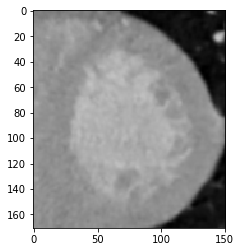

In [4]:
#img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(img)
plt.show()

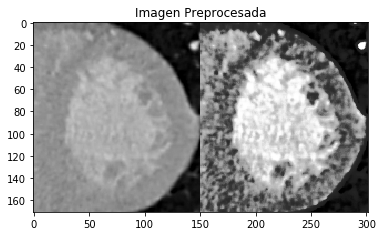

In [5]:
def preproces(img):
    '''
    Hace un preprocesamiento de la imagen aplicando unsharp mask y después 
    la equaliza. Esto para poder tener más definidas las regiones. 
    
    Args
    ------
    img -- Imagen cargada con OpenCV
    
    Return
    ------
    equ -- imagen ecualizada
    res -- comparativo entre imagen ecualizada y original
    
    '''
    # Aplicamos unsharp mask
    gaussian_3 = cv2.GaussianBlur(img, (9,9), 10.0)
    img = cv2.addWeighted(img, 1.5, gaussian_3, -0.5, 0, img)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Equalizamos la imagen para mejorar la diferencias de contrastes utilizando cdf.
    equ = cv2.equalizeHist(img)
    
    # Unimos las imagenes lado a lado para mostrarlas
    res = np.hstack((img,equ))

    return equ, res

# Preprocesamos la imagen
equ,res = preproces(img)

#Guardamos la imagen preprocesada
cv2.imwrite('./imagenes/processed.png',equ)

# Mostramos el resultado de la imagen procesada
plt.imshow(res, cmap='gray')
plt.title("Imagen Preprocesada")
plt.show()


In [6]:
# Cargamos la imagen preprocesada.
img = cv2.imread('./imagenes/processed.png', 1)


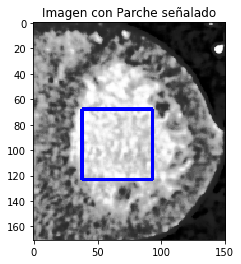

In [7]:
# Graficamos un rectangulo en donde vamos a seleccionar una ventana.
img_rect = img
img_rect = cv2.rectangle(img_rect,(38,68),(93,123),(0,0,255),2)

plt.imshow(img_rect)
plt.title("Imagen con Parche señalado")
plt.show()
plt.clf()

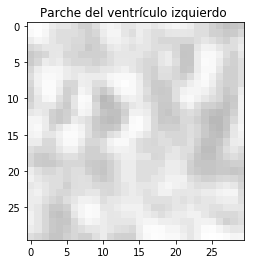

In [8]:
# Tomamos un parche de (50,50)
parche = img[90:120, 40:70] 

plt.imshow(parche)
plt.title("Parche del ventrículo izquierdo ")
plt.show()

# Por alguna razon matplot no reiniciaba la imagen original y aparecia con
# el rectangulo que habiamos dibujado encima, por lo que fue necesario volver
# a carga la imagen.

img = cv2.imread('./imagenes/processed.png', 1)


In [9]:
cumul_hist = 0

# Cortamos la imagen en el parche que buscamos [yi:yf,xi:xf]
parchecv = img[90:120, 40:70]
vector_acumulado = [0,0,0,0,0,0,0]

# Usamos sklearn para cortar el parche en piezas más chicas que usaremos para generar
# el histograma promedio. Hicimos 15 cortes de 20x20 en este caso.
from sklearn.feature_extraction import image
cortes = image.extract_patches_2d(parchecv, (20,20), max_patches=15)

for corte in cortes:
    vector_temp = []
    # Obtenemos la suma de histogramas de los cortes del parche
    cumul_hist += cv2.calcHist([corte],[0],None,[256],[0,256])
    # Obtenemos el vector caracteristico del corte
    vector_temp = vector_caract(corte)
    vector_acumulado = [vector_acumulado[i] + vector_temp[i] for i in range(len(vector_temp))]

Vector Promedio: [4.6692607003891045, 385.02065296692609, 0.0, 237.43253458333336, -602.31981840624815, 131344.12601542828, 5.9890775111221419]


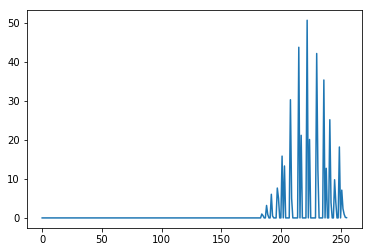

In [10]:
# Hacemos el promedio de los histogramas y el vector caracteristico.
promedio_hist = cumul_hist/15
vector_promedio = [valor / 15 for valor in vector_acumulado]
print("Vector Promedio: {0}".format(vector_promedio))

# Graficamos el histograma promedio
plt.plot(promedio_hist)
plt.show()

In [11]:
# img = cv2.imread('./imagenes/processed.png', 1)

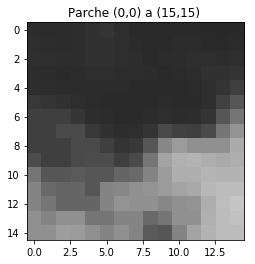

In [12]:
# Obtenemos un parche para probar que funcione el algoritmo.
# Este parche es de 15x15
parche2 = img[0:15, 0:15]

# Mostramos el parche
plt.imshow(parche2)
plt.title("Parche (0,0) a (15,15) ")
plt.show()

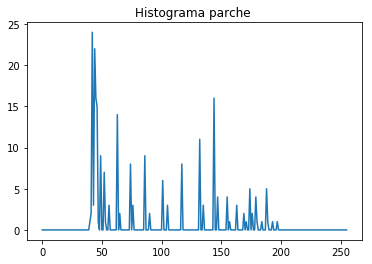

In [13]:
# Calculamos el histograma del parche.
hist_parche = cv2.calcHist([parche2],[0],None,[256],[0,256])

# Graficamos el histograma del parche
plt.plot(hist_parche)
plt.title("Histograma parche ")
plt.show()

Valor de Distancia Chi: 393.97178496865564


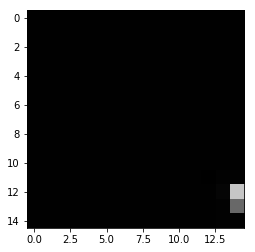

In [14]:
# Aplicamos chisquare entre el histograma del parche y el histograma promedio.
chi = chisquare2(hist_parche, promedio_hist)

# Imprimimos y gráficamos los resultados. Como vemos quwe funcionó, aplicaremos el mismo proceso
# pero a toda la imagen.
print("Valor de Distancia Chi: {0}".format(chi[0]))
res = chiImg(parche2, chi[1])
plt.imshow(res)
plt.show()

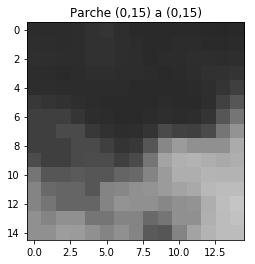

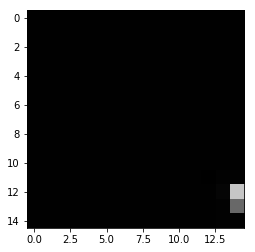

Vector Caracateristico: [2.6264591439688716, 86.977109678988299, 0.0, 2441.6700444444446, 86488.071092148122, 11956987.75362503, 5.2657177625826019]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


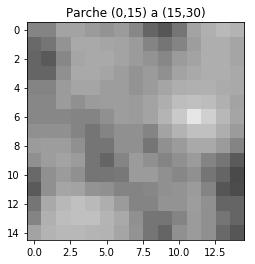

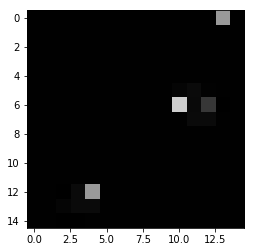

Vector Caracateristico: [2.6264591439688716, 112.07867217898831, 0.0, 687.7023999999999, -7080.4899223703496, 1519431.700761979, 5.3998651014699206]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


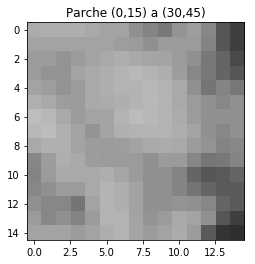

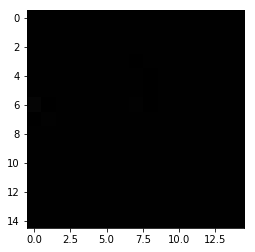

Vector Caracateristico: [2.6264591439688716, 124.73492217898834, 0.0, 755.66024691358029, -30587.419676268866, 2930317.8670763611, 5.3972392156470743]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


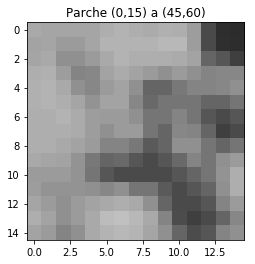

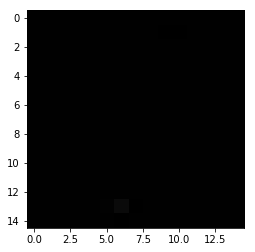

Vector Caracateristico: [2.6264591439688716, 92.953672178988327, 0.0, 1241.2522666666666, -33203.185877333344, 3961422.3248179215, 5.3801640788341984]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


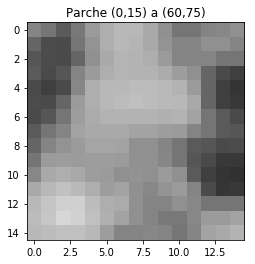

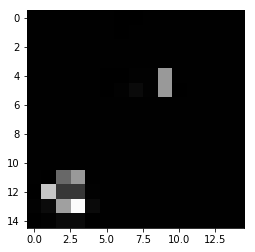

Vector Caracateristico: [2.6264591439688716, 76.641172178988327, 0.0, 1583.2424691358026, -34404.238639231822, 5906145.5614434388, 5.3716481196165571]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


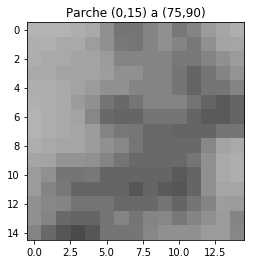

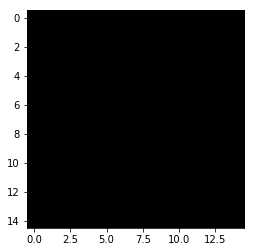

Vector Caracateristico: [2.6264591439688716, 145.61773467898831, 0.0, 682.97058765432098, 1059.0754261508666, 876165.5183331368, 5.3968134322827597]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


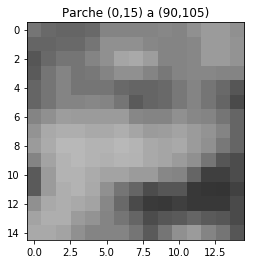

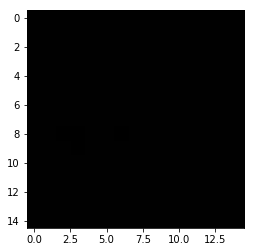

Vector Caracateristico: [2.6264591439688716, 112.35992217898833, 0.0, 1083.2898765432099, -15162.069113854639, 2880949.6196579803, 5.3818589673924162]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


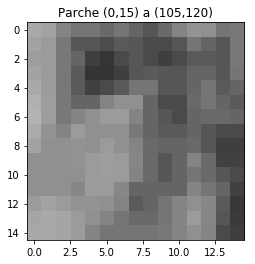

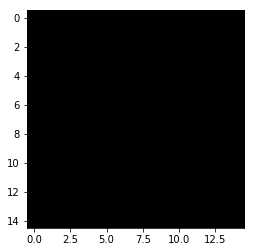

Vector Caracateristico: [2.6264591439688716, 119.25054717898831, 0.0, 968.03583209876535, -2111.8067166639335, 1848516.3858765771, 5.3794320475936797]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


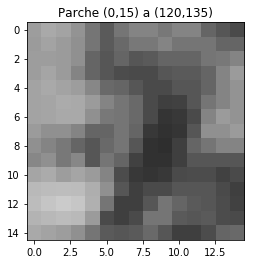

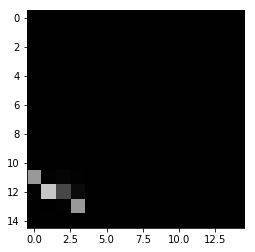

Vector Caracateristico: [2.6264591439688716, 92.953672178988313, 0.0, 1472.0255999999999, 13907.098685629629, 4421273.8642265126, 5.3593186518814386]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


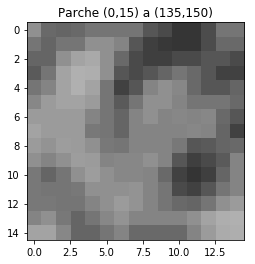

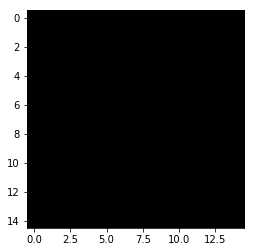

Vector Caracateristico: [2.6264591439688716, 136.68804717898834, 0.0, 883.73135802469142, -9652.2131577503624, 1937125.0484821219, 5.3835482006080815]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


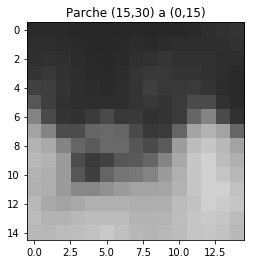

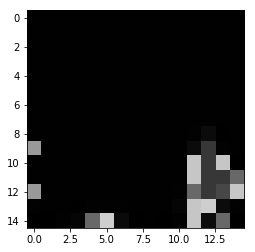

Vector Caracateristico: [2.6264591439688716, 52.523984678988334, 0.0, 3869.879980246913, 70816.207288713296, 20089941.549477134, 5.247686627287889]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


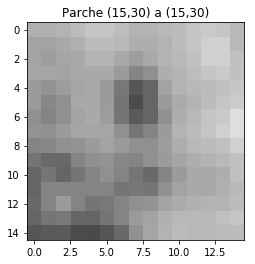

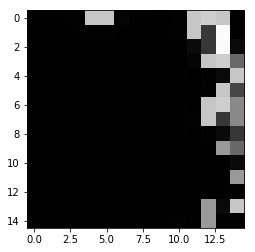

Vector Caracateristico: [2.6264591439688716, 73.125547178988327, 0.0, 1027.3873777777778, -18835.55676918519, 2761874.1109412978, 5.3943206969932334]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


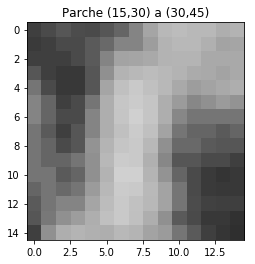

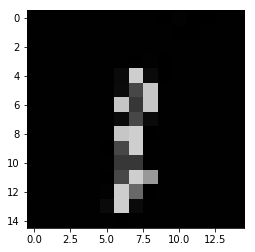

Vector Caracateristico: [2.6264591439688716, 66.797422178988327, 0.0, 2320.5660444444447, -15317.992244148223, 8694018.1494180989, 5.3450881929666751]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


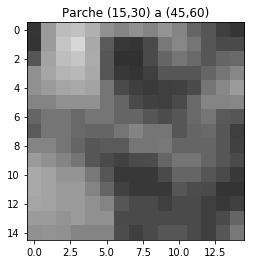

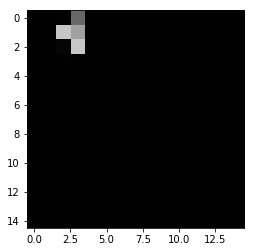

Vector Caracateristico: [2.6264591439688716, 111.37554717898831, 0.0, 1411.6898765432099, 23162.986886145394, 4594099.6108876094, 5.3553413133391121]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


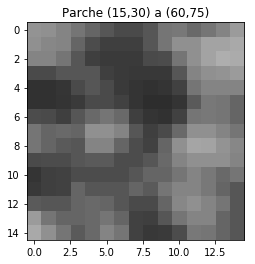

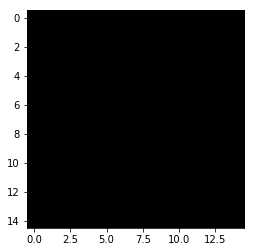

Vector Caracateristico: [2.6264591439688716, 113.48492217898831, 0.0, 1032.0897580246915, 8051.2106190836957, 2234458.6964625898, 5.3635821424155221]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


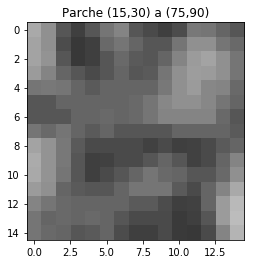

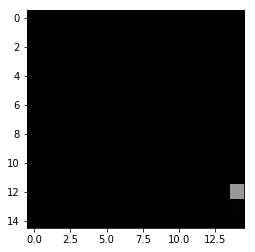

Vector Caracateristico: [2.6264591439688716, 162.49273467898834, 0.0, 825.56175802469136, 14492.461487582996, 1940136.6572936415, 5.3794525146063865]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


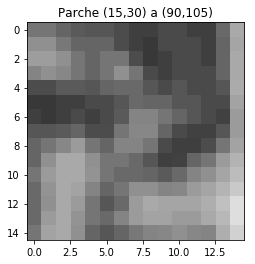

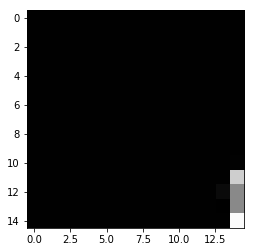

Vector Caracateristico: [2.6264591439688716, 105.53960967898833, 0.0, 1468.2118320987656, 21801.889027336059, 4868274.6775098797, 5.3605802256455846]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


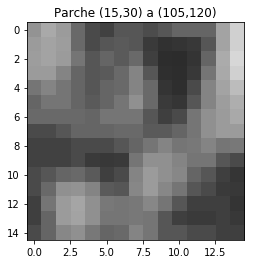

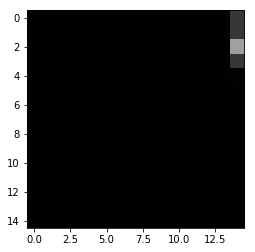

Vector Caracateristico: [2.6264591439688716, 104.69585967898834, 0.0, 1328.5756839506173, 23650.98146431824, 4885732.4452108806, 5.3565669945655614]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


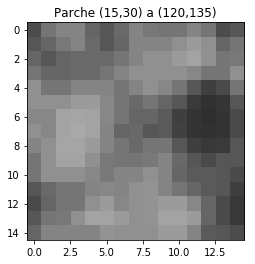

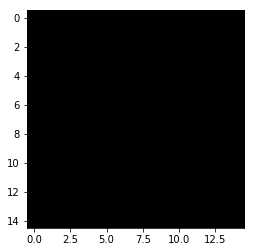

Vector Caracateristico: [2.6264591439688716, 143.43804717898831, 0.0, 902.26765432098773, -12392.38318792867, 1959425.0953452217, 5.3807813096281087]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


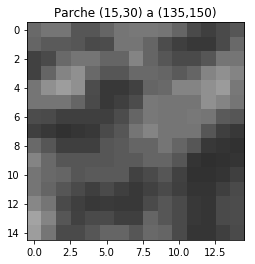

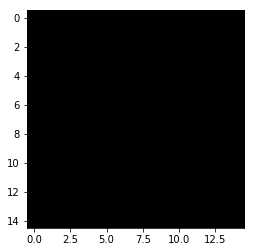

Vector Caracateristico: [2.6264591439688716, 140.76617217898831, 0.0, 715.57404444444433, 8127.9427839999926, 1220188.2516559644, 5.371893837577832]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


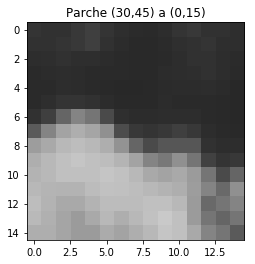

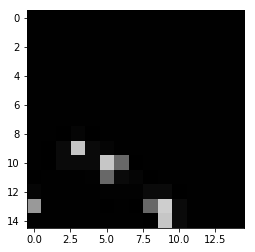

Vector Caracateristico: [2.6264591439688716, 63.141172178988334, 0.0, 3745.4438320987651, 87252.002734002817, 19170930.208545379, 5.2330946497582076]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


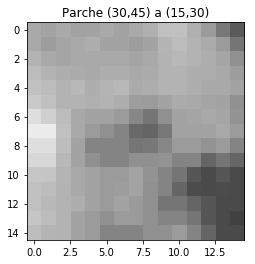

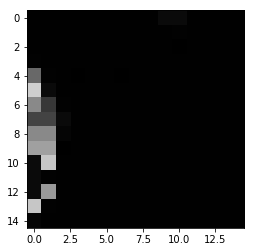

Vector Caracateristico: [2.6264591439688716, 97.805234678988313, 0.0, 1079.0211555555557, -28339.65675140739, 4330482.6327906605, 5.3918193468937705]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


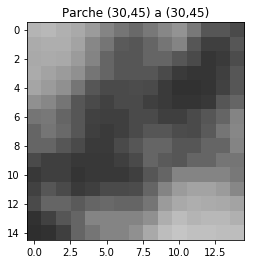

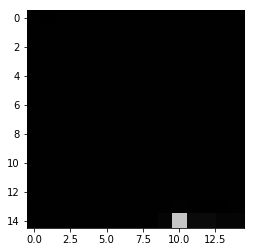

Vector Caracateristico: [2.6264591439688716, 108.4224221789883, 0.0, 1632.2126617283948, 38360.196876466391, 5882742.5172829926, 5.3435249309736861]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


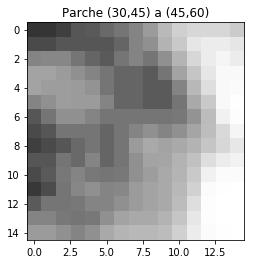

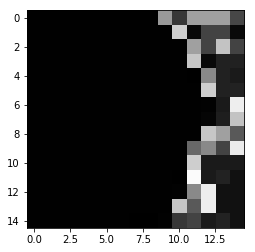

Vector Caracateristico: [2.6264591439688716, 73.055234678988327, 0.0, 2905.4193777777782, 57767.45095585176, 18129603.409137208, 5.3561139989120683]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


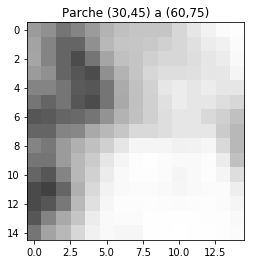

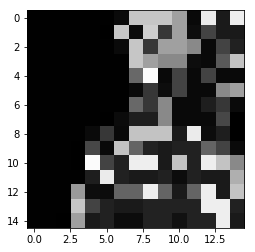

Vector Caracateristico: [2.6264591439688716, 52.594297178988327, 0.0, 3077.4517333333329, -130156.40202429629, 21435153.321025796, 5.3712490357081162]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


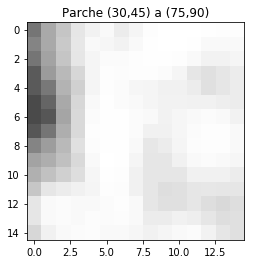

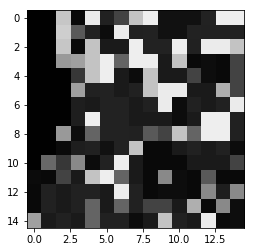

Vector Caracateristico: [2.6264591439688716, 97.242734678988299, 0.0, 1450.8437728395063, -132220.69639760768, 17625673.692566875, 5.3995010964081525]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


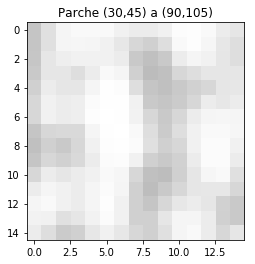

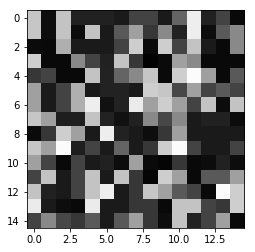

Vector Caracateristico: [2.6264591439688716, 99.984922178988327, 0.0, 326.13123950617279, -3012.8822393854457, 224670.89805697097, 5.4129469240042383]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


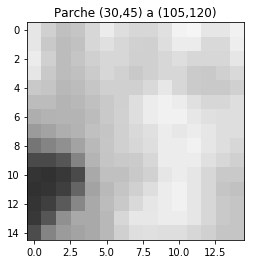

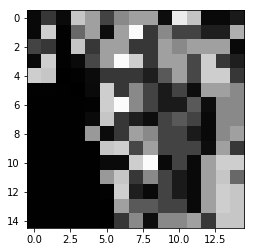

Vector Caracateristico: [2.6264591439688716, 88.805234678988327, 0.0, 1920.7548839506171, -166288.15125631812, 24076426.021097571, 5.3853835465355724]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


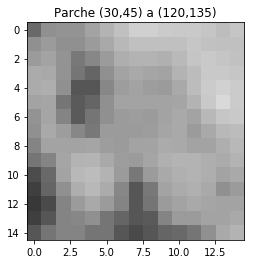

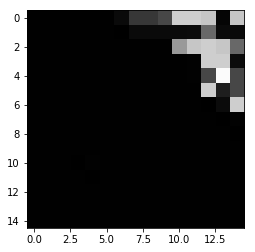

Vector Caracateristico: [2.6264591439688716, 83.602109678988313, 0.0, 1082.401698765432, -30316.567776219461, 3907312.4155093669, 5.3916425222406197]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


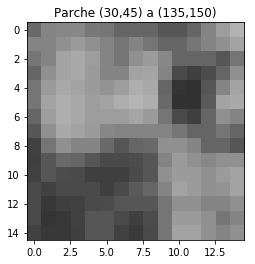

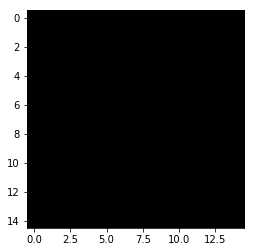

Vector Caracateristico: [2.6264591439688716, 115.80523467898831, 0.0, 1306.900424691358, -8719.1650653058696, 3031444.7627678532, 5.3664671266459285]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


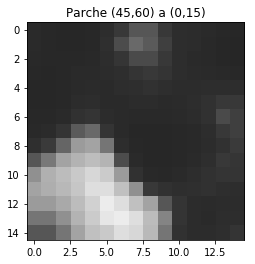

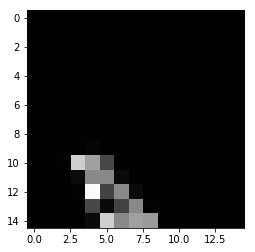

Vector Caracateristico: [2.6264591439688716, 81.352109678988342, 0.0, 3308.2049580246903, 277554.731951583, 39392731.416653164, 5.1905289897601401]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


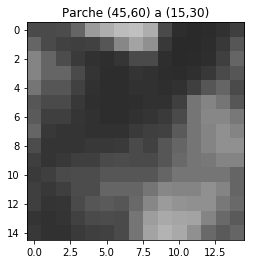

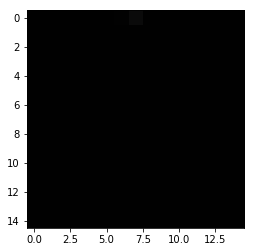

Vector Caracateristico: [2.6264591439688716, 84.586484678988313, 0.0, 1336.7382913580248, 40752.941378194773, 4916133.4909800803, 5.3298183248795681]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


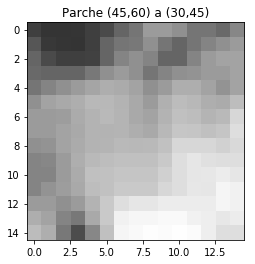

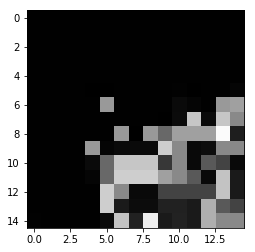

Vector Caracateristico: [2.6264591439688716, 51.32867217898832, 0.0, 2370.462498765432, -45002.859551780602, 15444880.669731589, 5.3705718855191886]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


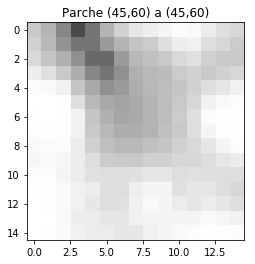

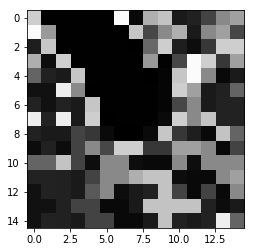

Vector Caracateristico: [2.6264591439688716, 63.422422178988334, 0.0, 1219.2720987654322, -53006.986293552764, 6748253.2348151775, 5.4018283372880145]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


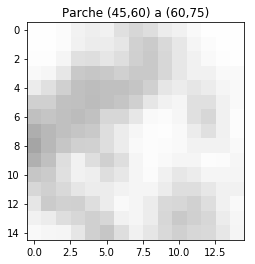

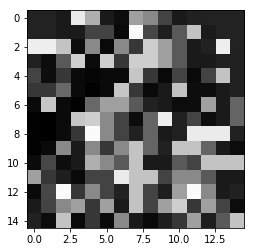

Vector Caracateristico: [2.6264591439688716, 83.391172178988313, 0.0, 415.99257283950612, -5221.2134322743532, 418887.1210592034, 5.4119993199091763]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


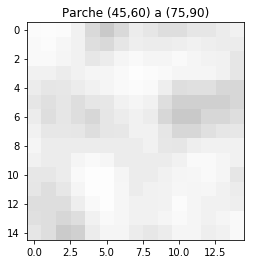

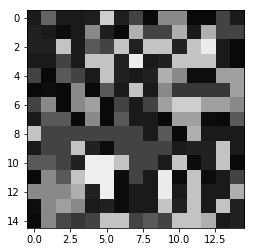

Vector Caracateristico: [2.6264591439688716, 162.14117217898831, 0.0, 132.91488395061728, -1380.6818103484279, 59853.779964539914, 5.4148869515971345]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


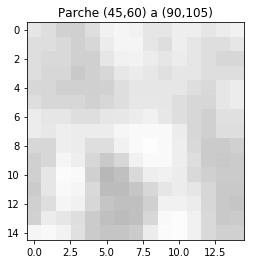

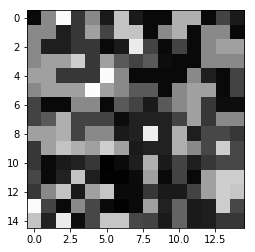

Vector Caracateristico: [2.6264591439688716, 126.21148467898833, 0.0, 248.06506666666667, -720.31157570370476, 140566.80175824597, 5.4135989435178029]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


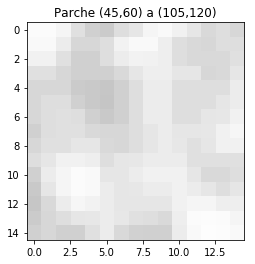

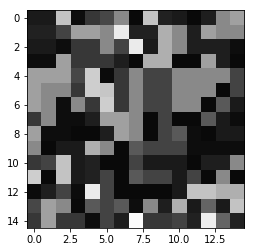

Vector Caracateristico: [2.6264591439688716, 142.73492217898831, 0.0, 170.73777777777778, -207.37600000000262, 68459.832177777789, 5.4144444052282381]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


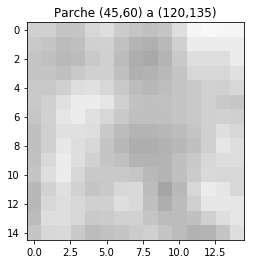

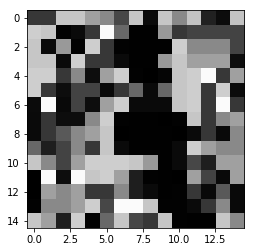

Vector Caracateristico: [2.6264591439688716, 110.3208596789883, 0.0, 288.10559999999998, 1134.319744000004, 207358.52761258668, 5.4126809598724854]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


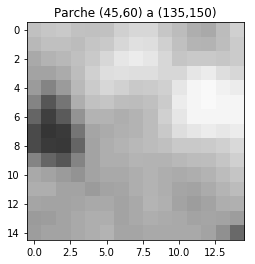

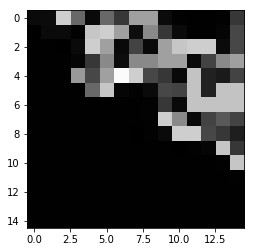

Vector Caracateristico: [2.6264591439688716, 67.781797178988313, 0.0, 1396.2913580246916, -51170.735824416974, 9807202.7718598973, 5.3921296000549201]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


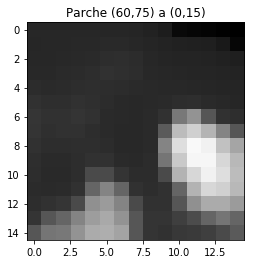

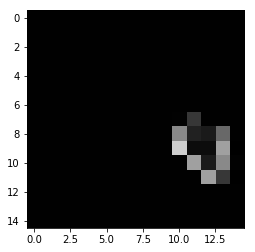

Vector Caracateristico: [2.6264591439688716, 59.977109678988342, 0.0, 3198.8692543209881, 281308.07031607139, 44170423.143719174, 5.168967855301358]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


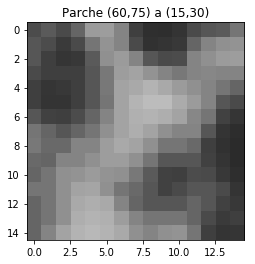

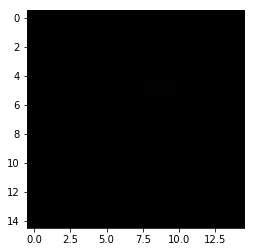

Vector Caracateristico: [2.6264591439688716, 87.680234678988327, 0.0, 1627.7851654320987, 1679.4589188916291, 4724336.4102000538, 5.3480944727637816]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


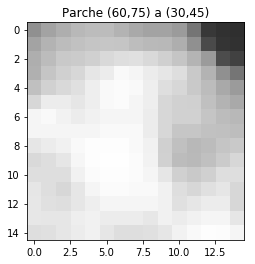

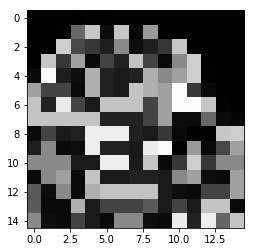

Vector Caracateristico: [2.6264591439688716, 66.938047178988327, 0.0, 1663.7784888888891, -140584.17087525927, 22674237.603909597, 5.393568483273592]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


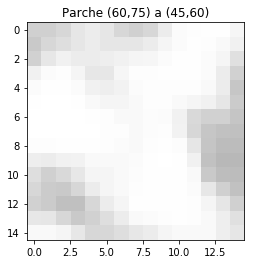

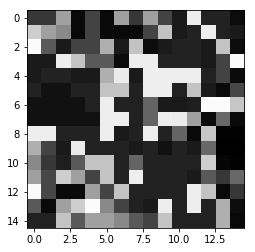

Vector Caracateristico: [2.6264591439688716, 106.45367217898833, 0.0, 384.33094320987658, -8228.7469003676342, 443183.29789891146, 5.4125616445946836]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


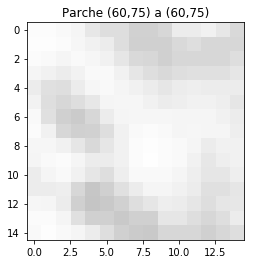

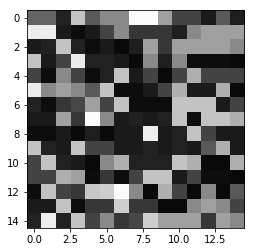

Vector Caracateristico: [2.6264591439688716, 118.8286721789883, 0.0, 207.72246913580247, -1629.5533607681784, 94416.445236031112, 5.4141589083730697]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


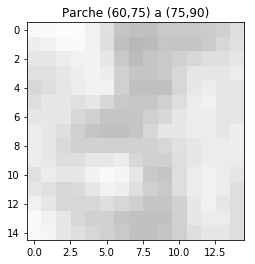

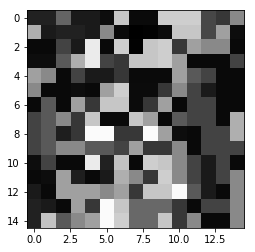

Vector Caracateristico: [2.6264591439688716, 133.10210967898831, 0.0, 269.39093333333341, -1364.0643602963059, 146547.71366153492, 5.4133158837619142]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


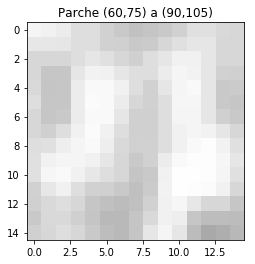

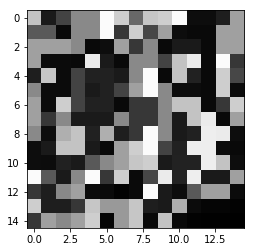

Vector Caracateristico: [2.6264591439688716, 91.266172178988313, 0.0, 360.20551111111115, -1193.581259851838, 285493.61859925324, 5.4124118016548355]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


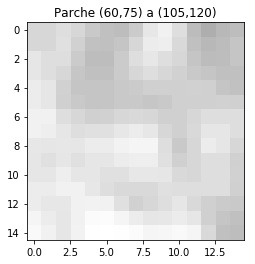

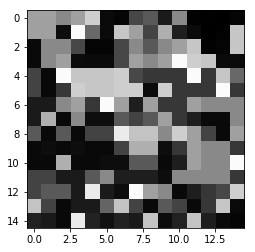

Vector Caracateristico: [2.6264591439688716, 101.88335967898833, 0.0, 293.32377283950615, -729.68186960769299, 194297.3606344329, 5.4130209238784577]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


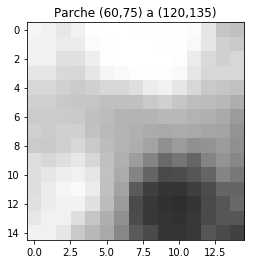

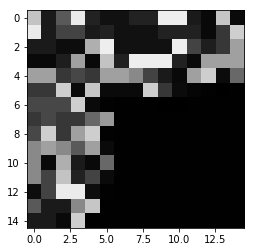

Vector Caracateristico: [2.6264591439688716, 39.305234678988327, 0.0, 3631.9039209876551, -194488.08505029348, 35367980.557708934, 5.3534995853891756]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


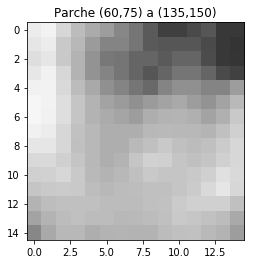

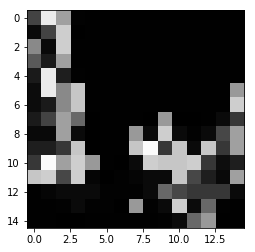

Vector Caracateristico: [2.6264591439688716, 52.805234678988327, 0.0, 2044.3032098765436, -90274.577997256551, 14013837.053534523, 5.3771062724612193]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


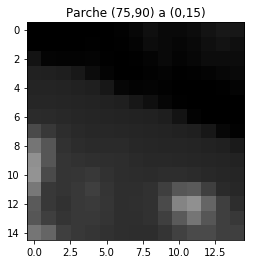

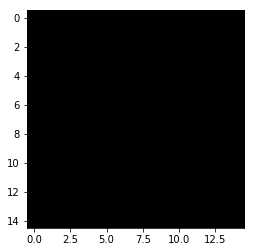

Vector Caracateristico: [2.6264591439688716, 54.281797178988313, 0.0, 913.63843950617286, 29647.118699281207, 3917027.5362763493, 5.0363967355399595]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


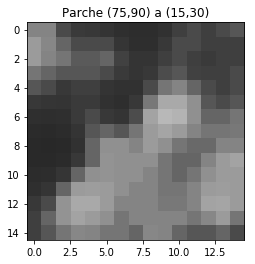

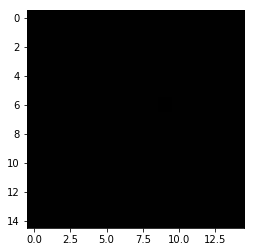

Vector Caracateristico: [2.6264591439688716, 93.164609678988313, 0.0, 1591.3563654320988, 9345.3700868916512, 4229740.8698357278, 5.3334874620429726]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


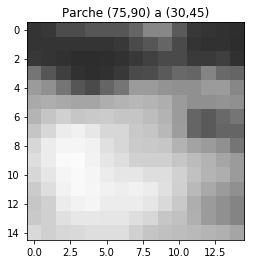

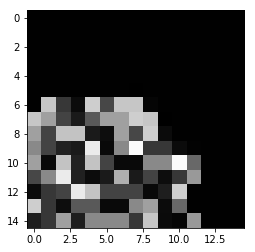

Vector Caracateristico: [2.6264591439688716, 40.992734678988327, 0.0, 4254.5491358024692, -107917.02713854602, 32469923.679685414, 5.319707198913501]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


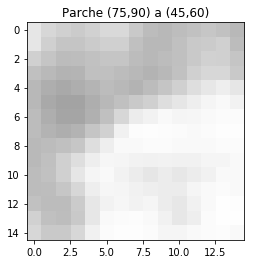

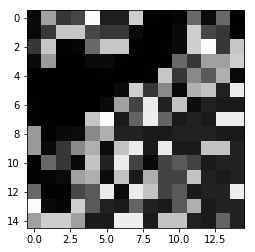

Vector Caracateristico: [2.6264591439688716, 65.883359678988327, 0.0, 751.65325432098757, -2636.1808227380138, 863093.42114921601, 5.4080594861439586]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


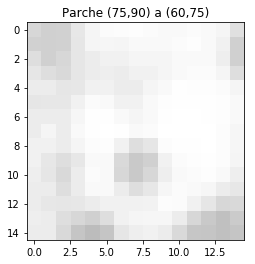

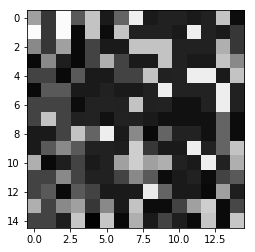

Vector Caracateristico: [2.6264591439688716, 110.03960967898831, 0.0, 248.05360987654322, -4416.1358852565072, 216839.43580263454, 5.4138398478163055]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


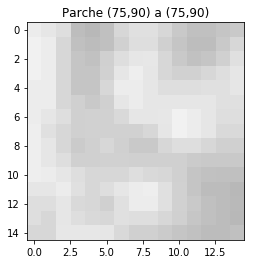

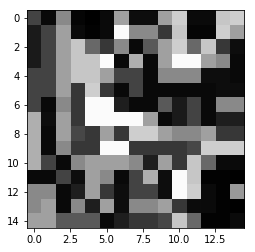

Vector Caracateristico: [2.6264591439688716, 131.41460967898831, 0.0, 225.92071111111113, -845.00974933332668, 106847.35062129775, 5.4136492385907209]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


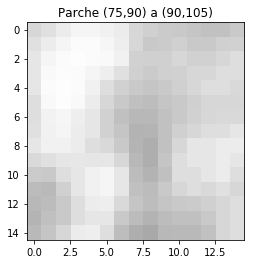

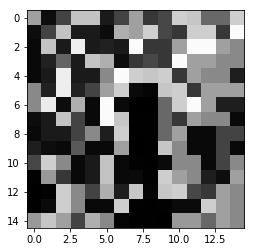

Vector Caracateristico: [2.6264591439688716, 91.406797178988327, 0.0, 413.70951111111117, -681.65853866665623, 367731.92486343108, 5.4116427529547808]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


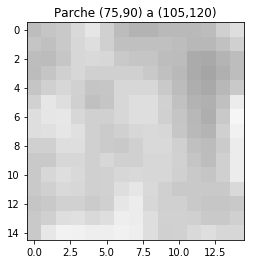

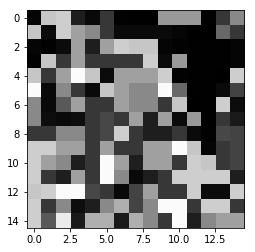

Vector Caracateristico: [2.6264591439688716, 130.64117217898831, 0.0, 252.10469135802472, -212.71626886144668, 186115.54298088705, 5.4131415778845655]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


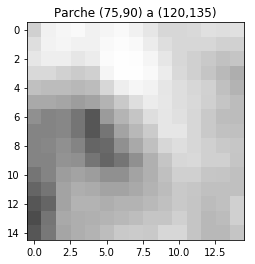

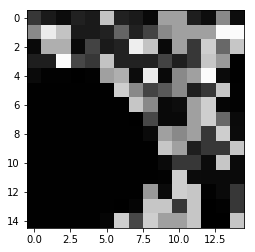

Vector Caracateristico: [2.6264591439688716, 50.344297178988327, 0.0, 1574.229609876543, -44227.337437410148, 7617424.6833589021, 5.392693235619527]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


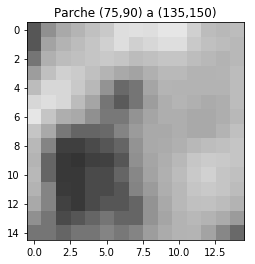

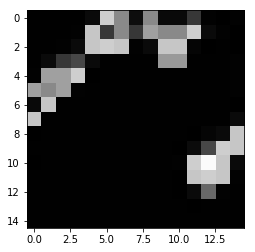

Vector Caracateristico: [2.6264591439688716, 58.078672178988327, 0.0, 2003.4064987654322, -71899.187231780525, 10491192.163337987, 5.3713354334941901]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


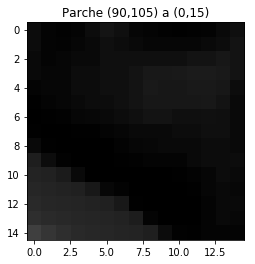

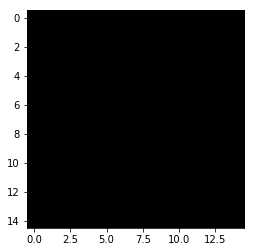

Vector Caracateristico: [2.6264591439688716, 118.89898467898827, 0.0, 150.57509135802468, 2177.5306901947865, 91180.269241888527, 4.9868185130441445]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


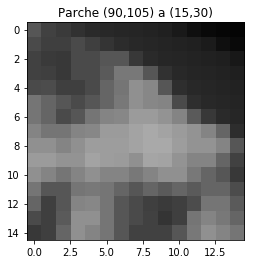

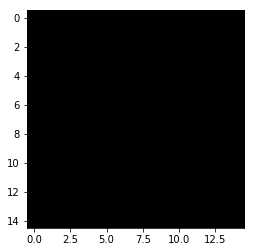

Vector Caracateristico: [2.6264591439688716, 73.758359678988327, 0.0, 1845.9451654320992, -3169.9459162249418, 6276393.6095079053, 5.2995614998562068]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


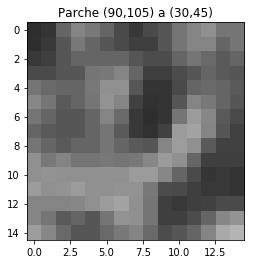

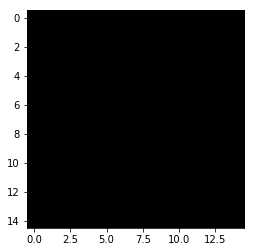

Vector Caracateristico: [2.6264591439688716, 117.21148467898833, 0.0, 1001.7960691358024, 1472.0722818984784, 2038706.2468316695, 5.3679497970271708]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


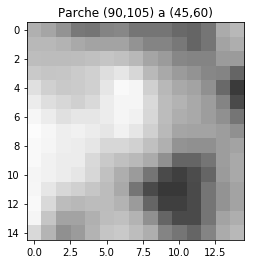

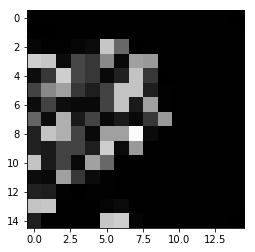

Vector Caracateristico: [2.6264591439688716, 47.039609678988313, 0.0, 2361.0976000000001, -45177.203906370283, 13958318.110148644, 5.3734415714146406]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


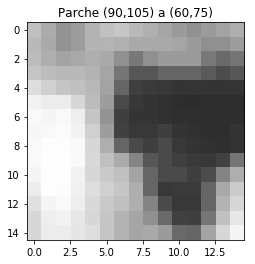

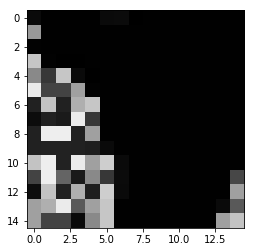

Vector Caracateristico: [2.6264591439688716, 36.14117217898832, 0.0, 4763.4001777777776, -41692.876766814683, 37928812.109499164, 5.2978682483905244]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


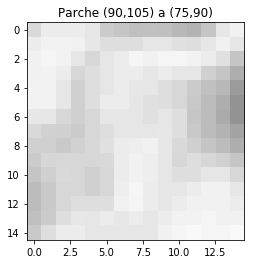

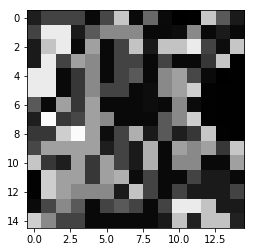

Vector Caracateristico: [2.6264591439688716, 134.93023467898831, 0.0, 386.09710617283946, -9344.2284864965695, 676457.1979432723, 5.4119961387143034]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


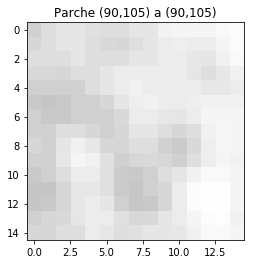

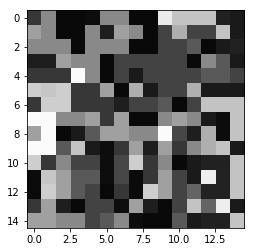

Vector Caracateristico: [2.6264591439688716, 132.39898467898831, 0.0, 209.97333333333333, -513.98162962963431, 93871.496770370373, 5.4140502332917801]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


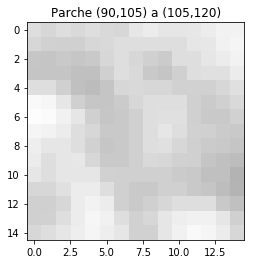

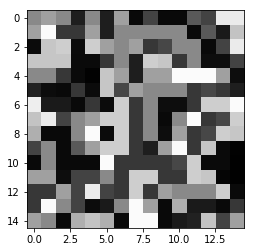

Vector Caracateristico: [2.6264591439688716, 134.93023467898834, 0.0, 231.34222222222223, 599.06666666665876, 127992.23182222219, 5.4136444248240743]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


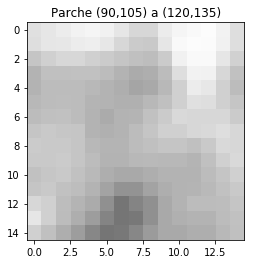

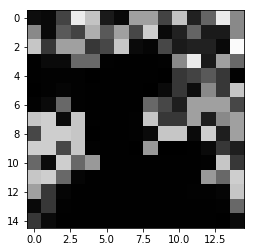

Vector Caracateristico: [2.6264591439688716, 66.094297178988327, 0.0, 724.36515555555548, -4445.3297493333139, 1889240.3998657421, 5.4062993892347651]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


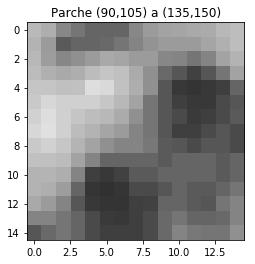

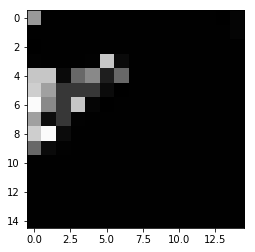

Vector Caracateristico: [2.6264591439688716, 75.445859678988313, 0.0, 2291.8165728395061, 22765.490978941052, 9658129.5040807147, 5.3438941374063074]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


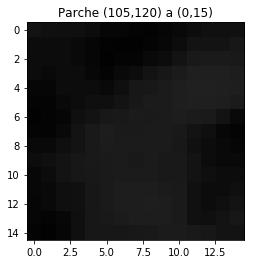

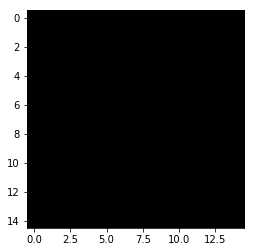

Vector Caracateristico: [2.6264591439688716, 116.93023467898827, 0.0, 75.265698765432091, -110.60513044718759, 9706.6822964487601, 5.2818985437710584]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


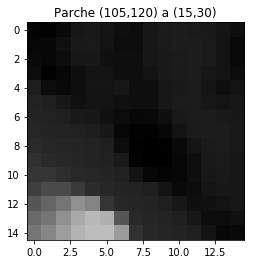

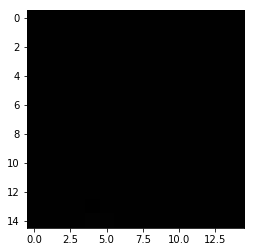

Vector Caracateristico: [2.6264591439688716, 61.24273467898832, 0.0, 1316.1106172839507, 132082.99316323732, 18134707.710293919, 5.0131550676545338]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


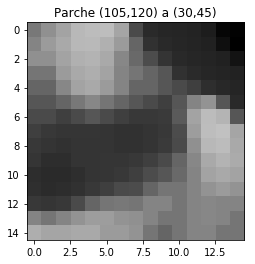

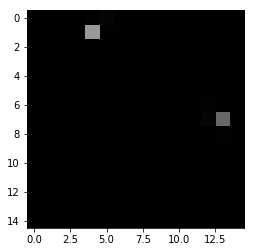

Vector Caracateristico: [2.6264591439688716, 58.219297178988327, 0.0, 2476.6016, 16363.657666370344, 10659575.208158245, 5.2843726288548201]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


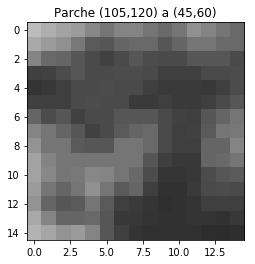

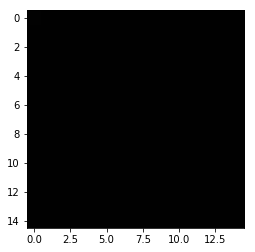

Vector Caracateristico: [2.6264591439688716, 114.04742217898831, 0.0, 1021.2220444444446, 24660.68741214816, 3020960.8053924986, 5.3561564920440796]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


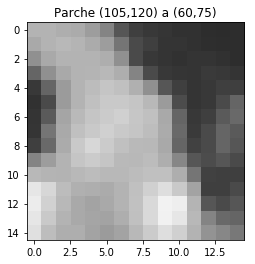

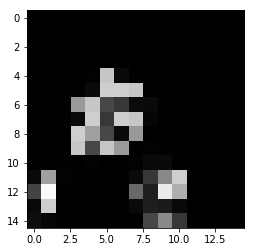

Vector Caracateristico: [2.6264591439688716, 47.531797178988313, 0.0, 3497.2306172839508, -67034.289163237423, 19739882.588160586, 5.3164831859408599]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


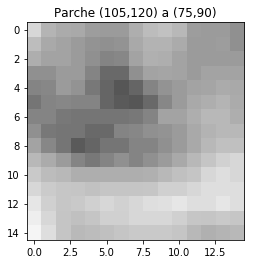

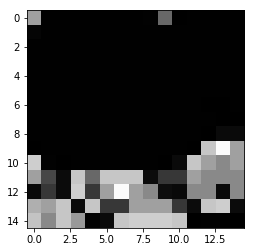

Vector Caracateristico: [2.6264591439688716, 72.000547178988327, 0.0, 1188.9134617283951, -7291.9168124664429, 3349537.1882988145, 5.39433819729582]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


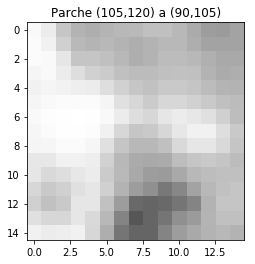

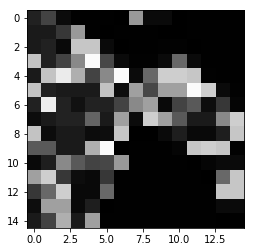

Vector Caracateristico: [2.6264591439688716, 46.82867217898832, 0.0, 1310.2716839506172, -29834.228184318235, 5723648.9608252207, 5.3986417495445878]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


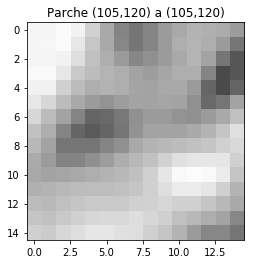

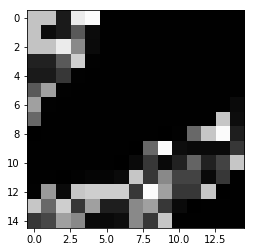

Vector Caracateristico: [2.6264591439688716, 52.172422178988327, 0.0, 1549.7966617283948, -16333.987169799695, 6479200.7640594058, 5.3908209821063355]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


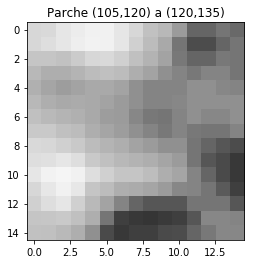

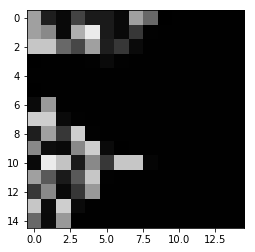

Vector Caracateristico: [2.6264591439688716, 55.195859678988327, 0.0, 2348.1264987654322, -23618.083552219512, 12517705.887559617, 5.3652476478610911]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


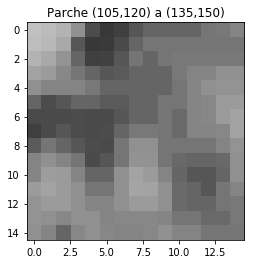

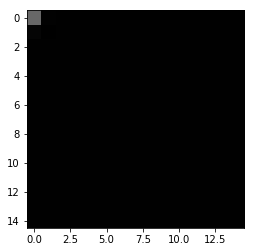

Vector Caracateristico: [2.6264591439688716, 152.57867217898831, 0.0, 777.74115555555545, -319.96928474072934, 1613470.3422875497, 5.388269265196671]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


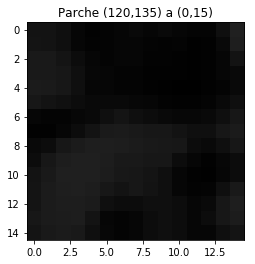

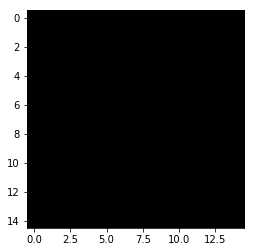

Vector Caracateristico: [2.6264591439688716, 115.66460967898827, 0.0, 88.748958024691348, 227.5495729163238, 13356.848662174962, 5.1735224488763443]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


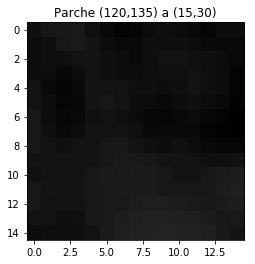

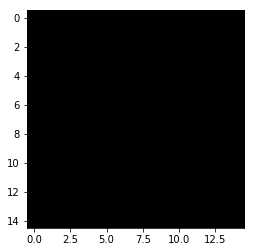

Vector Caracateristico: [2.6264591439688716, 150.8208596789884, 0.0, 55.511822222222222, 47.925717333333253, 7563.0388844088875, 5.3179865893508804]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


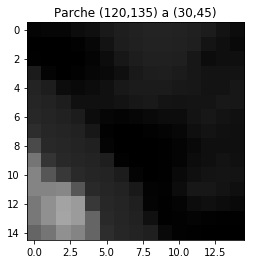

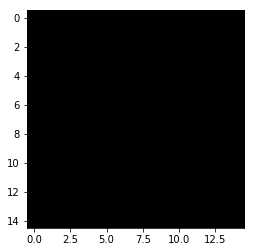

Vector Caracateristico: [2.6264591439688716, 60.258359678988334, 0.0, 1228.6209580246912, 98840.929275083661, 11842545.92629512, 4.8668851630792265]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


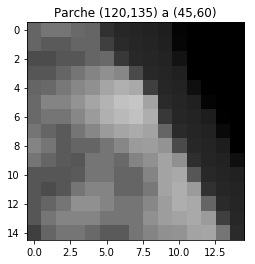

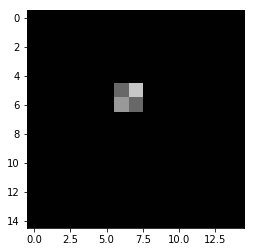

Vector Caracateristico: [2.6264591439688716, 82.898984678988313, 0.0, 2999.4286617283951, -25103.794035533647, 17175595.060223911, 5.1714318901787806]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


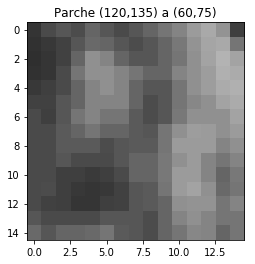

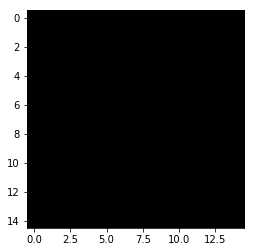

Vector Caracateristico: [2.6264591439688716, 121.14898467898831, 0.0, 1110.1624888888889, 10328.599509333324, 2495905.277118009, 5.3664518460355222]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


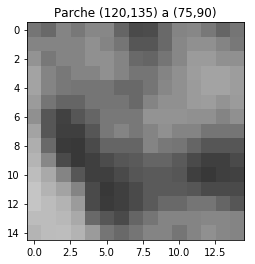

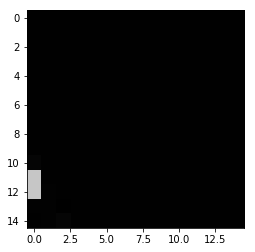

Vector Caracateristico: [2.6264591439688716, 116.71929717898833, 0.0, 1126.4167111111112, 1512.4169291851695, 3060553.8775148089, 5.375291464944306]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


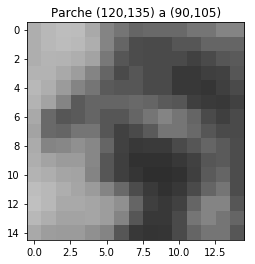

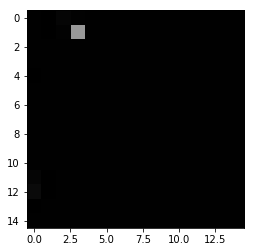

Vector Caracateristico: [2.6264591439688716, 89.438047178988327, 0.0, 1786.2248691358025, 30306.888742101546, 6008793.2129633445, 5.3424536395783626]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


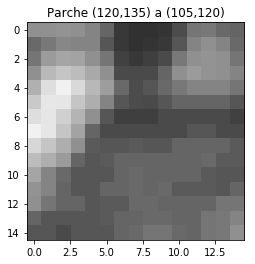

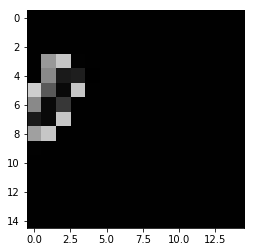

Vector Caracateristico: [2.6264591439688716, 144.14117217898831, 0.0, 1696.7937580246912, 80418.557605750364, 11436512.345735952, 5.3555601525200185]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


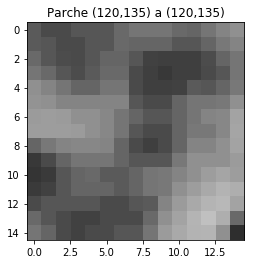

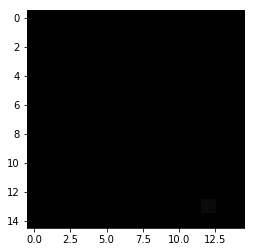

Vector Caracateristico: [2.6264591439688716, 127.40679717898833, 0.0, 1073.4883950617284, 14682.26368175584, 2653330.3849540013, 5.3713495353957885]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


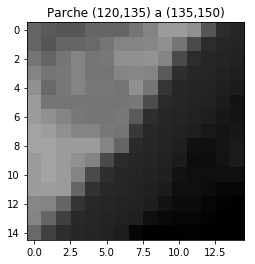

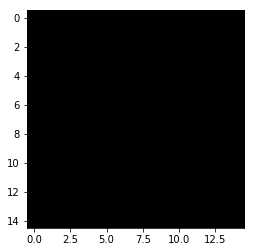

Vector Caracateristico: [2.6264591439688716, 58.570859678988327, 0.0, 2700.0809876543212, 31821.501256515821, 11115784.47849584, 5.1369966505840718]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


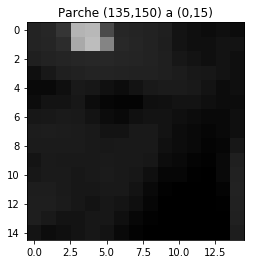

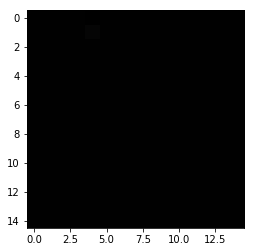

Vector Caracateristico: [2.6264591439688716, 94.008359678988271, 0.0, 637.43103209876551, 74807.944060663925, 11781735.637577198, 5.0372786672365795]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


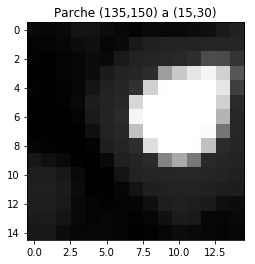

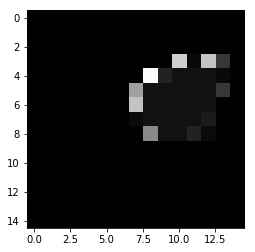

Vector Caracateristico: [2.6264591439688716, 56.672422178988342, 0.0, 6772.9893135802467, 943111.95754649106, 192845791.9581562, 4.6144228480124543]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


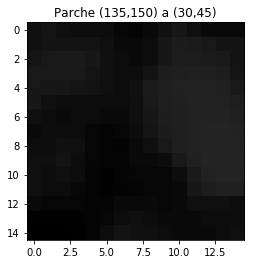

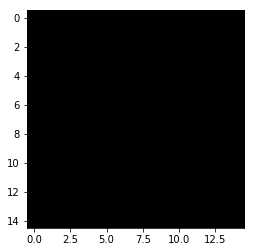

Vector Caracateristico: [2.6264591439688716, 123.82085967898831, 0.0, 99.822933333333339, 382.31191229629678, 19828.849823668152, 5.2291404513404842]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


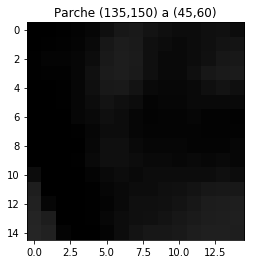

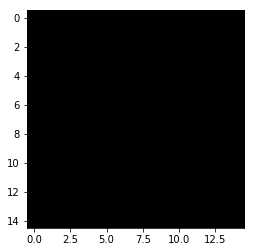

Vector Caracateristico: [2.6264591439688716, 128.81304717898831, 0.0, 90.010587654320986, 569.26697384910824, 20014.465125433122, 5.029295454273857]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


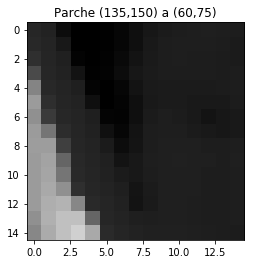

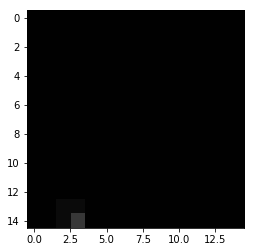

Vector Caracateristico: [2.6264591439688716, 80.438047178988299, 0.0, 2109.7765135802465, 202260.40601582441, 27278463.690319482, 5.0133946508251963]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


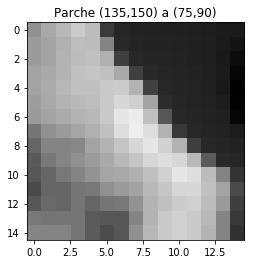

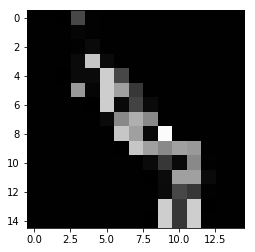

Vector Caracateristico: [2.6264591439688716, 37.266172178988327, 0.0, 4639.7510320987649, -70847.45552733056, 34303998.264217794, 5.2393493521760952]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


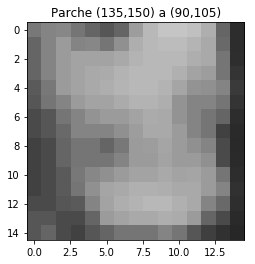

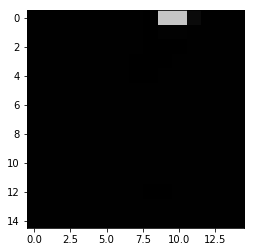

Vector Caracateristico: [2.6264591439688716, 86.484922178988327, 0.0, 1759.7519802469139, -38472.757873953342, 6679307.3503129268, 5.3587901985420263]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


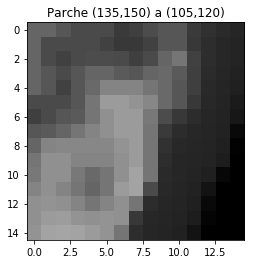

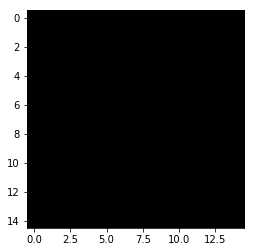

Vector Caracateristico: [2.6264591439688716, 65.250547178988342, 0.0, 2180.6552888888891, 2503.2024272592421, 8807702.7541005276, 5.2297465879029472]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


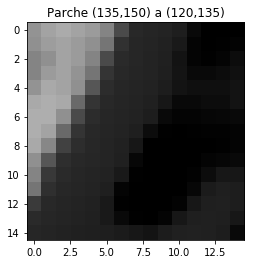

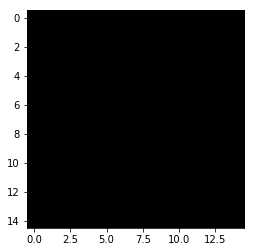

Vector Caracateristico: [2.6264591439688716, 55.125547178988313, 0.0, 2704.373609876543, 191148.21481858988, 25438451.873553157, 4.8566933856332763]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


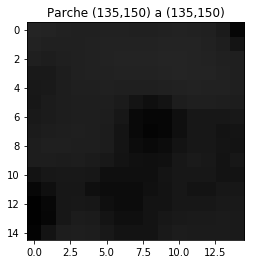

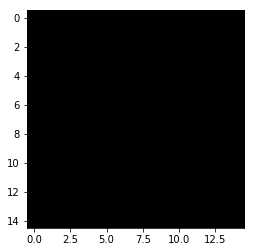

Vector Caracateristico: [2.6264591439688716, 99.211484678988342, 0.0, 63.508424691358009, -424.26170802743496, 12731.145441394716, 5.3547136380485405]
Distancia Espacial: 47952.651503471425
Valor de Distancia Chi: 393.97178496865564


In [15]:
img_dis  = []
window_size = 15
i = 1
res = []
temp = []
vect_dist = []

# Cortamos la imagen en secciones de 15x15 (window_size) y realizamos el mismo proceso que hicimos
# antes a cada corte que hacemos de la imagen.
for i in range(int(img.shape[0]/window_size)-1): 
    for j in range(int(img.shape[1]/window_size)):
        
        # Obtenemos las x,y iniciales y finales
        xi,yi,xf,yf = i*window_size,j*window_size,i*window_size+window_size,j*window_size+window_size
        
        # Obtenemos el arreglo de pixeles del parche y lo mostramos
        parche2 = img[yi:yf,xi:xf]
        plt.imshow(parche2)
        plt.title("Parche ({0},{1}) a ({2},{3})".format(xi,xf,yi,yf))
        plt.show()
        
        # Calculamos CHI y graficamos la imagen resultante de la distancia. 
        chi = chisquare2(hist_parche,promedio_hist )
        res = chiImg(parche2, chi[1])
        temp.append(res)
        plt.imshow(res)
        plt.show()
        
        # Calculamos Vector Caracteristico
        vect_temp = vector_caract(parche2)
        vectores = np.concatenate((np.array([vector_temp]),np.array([vector_promedio])), axis=0)
        
        # Calculamos la distancia euclidiana del vector caracteristico del parche y el promedio y lo guardamos
        # en un np.array
        vect_dist.append(cdist(vectores,vectores)[0])
        
        # Imprimimos los resultados
        print("Vector Caracateristico: {0}".format(vect_temp))
        print("Distancia Espacial: {0}".format(vect_dist[-1][1]))
        print("Valor de Distancia Chi: {0}".format(chi[0]))
        print("=================================================")

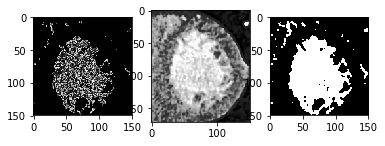

In [16]:
vertical = []

# Reconstruccion a una sola imagen. Unimos todos los pedazos de imagenes obtenidos antes y 
# construimos la imagen con los resultados.
for i in range(0, 10):
    test = np.vstack(temp[i*10:10*(i+1)])
    vertical.append(test)
    
end = np.hstack(vertical)

# Binarisamos el resultado para hacer más claro en donde esta el segmento de la imagen buscado.
ret,thresh = cv2.threshold(end,127,1,cv2.THRESH_BINARY_INV)

# Grafica final 
plt.subplot(1,3,1)
plt.imshow(end)
plt.subplot(1,3,2)
plt.imshow(img)
plt.subplot(1,3,3)
plt.imshow(thresh)

plt.show()


### Limitaciones
- El algoritmo que usamos no consideró cortes que no fueran de 15x15 por lo que si queda un residuo en la imagen de pixeles de un tamaño distinto, digamos de 150 a 151, el algoritmo no los consideró. 
- El método de reconstrucción no es lo óptimo pero no fue posible reconstruir la imagen utilizando sklearn.